In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.interpolate import interp1d
import peakutils
%matplotlib notebook

ecg_original = []
ppg_original = []
line_count = 0
with open('./testing_data/P0008_B_1.txt', 'r') as f:
    line = f.readline()
    while (line):
        if (line_count >= 5):
            _ = line.split()
            ecg_original.append(float(_[1]))
            ppg_original.append(float(_[2]))
        line_count += 1
        line = f.readline()

In [6]:
'''
Inputs:
ecg_original:raw ecg
fs:sampling rate
gr:flag to plot 1 is plot 0 is not plot

Outputs:
ecg_h:complete high pass
qrs_amp_raw:amplitude of R waves amplitudes
qrs_i_raw:index of R waves
delay:number of samples which the signal is delayed due to the filtering
'''

'''
This function is copy from matlab pan_tompkin function and not made by me
matlab pan_tompkin
https://www.mathworks.com/matlabcentral/fileexchange/45840-complete-pan-tompkins-implementation-ecg-qrs-detector
'''

def pan_tompkin(ecg_original, fs=1000, gr=1):
    delay = 0
    skip = 0
    m_selected_RR = 0
    mean_RR = 0
    ser_back = 0 
    
    if (fs == 200):
        # Low pass and High pass
        # Low pass
        wn = 12 * 2 / fs
        N = 3                                                              
        a, b = signal.butter(N, wn, 'low')
        ecg_l = signal.filtfilt(a, b, ecg_original)
        ecg_l = ecg_l / max(abs(ecg_l))
        ecg_l = np.around(ecg_l, decimals=4)

        # High pass
        wn = 5 * 2 / fs
        N = 3                                          
        a, b = signal.butter(N, wn, 'high')                                        
        ecg_h = signal.filtfilt(a, b, ecg_original) 
        ecg_h = ecg_h / max(abs(ecg_h))

        """"
        plt.title('Low pass')
        plt.figure()
        plt.subplot(211)
        plt.plot(ecg_l)
        plt.subplot(212)
        plt.title('High pass')
        plt.plot(ecg_h)
        """

    else:
        # Bandpass
        f1 = 5                                                  
        f2 = 15
        wn = []
        wn.append(f1 * 2 / fs)
        wn.append(f2 * 2 / fs)
        N = 3                                                     
        a, b = signal.butter(N, wn, 'bandpass')                                                  
        ecg_h = signal.filtfilt(a, b, ecg_original)
        ecg_h = ecg_h / max(abs(ecg_h))

        '''
        plt.figure()
        plt.title('Bandpass')
        plt.plot(ecg_h)
        '''

    # Derivative
    int_c = (5 - 1) / (fs * 1 / 40)
    x = np.arange(1,6)
    xp = np.dot(np.array([1, 2, 0, -2, -1]), (1 / 8) * fs)
    fp = np.arange(1,5+int_c,int_c)
    b = np.interp(fp, x, xp)
    ecg_d = signal.filtfilt(b, 1, ecg_h)
    ecg_d = ecg_d / max(ecg_d)
    '''
    plt.figure()
    plt.title('Derivative')
    plt.plot(ecg_d)
    '''

    # Squaring and Moving average
    ecg_s = np.power(ecg_d, 2)
    ecg_m = np.convolve(ecg_s ,np.ones(int(np.around(0.150*fs)))/np.around(0.150*fs))
    delay = delay + np.around(0.150*fs) / 2

    '''
    plt.figure()
    plt.title('Average')
    plt.plot(ecg_m)
    '''

    # Fiducial Marks
    locs = peakutils.indexes(ecg_m, thres=0, min_dist=np.around(0.2 * fs))
    pks = ecg_m[locs[:]]
    '''
    plt.figure()
    plt.title('Peaks')
    plt.plot(ecg_m)
    plt.plot(locs, ecg_m[locs], "x")
    '''

    # Init other parameters
    LLp = len(pks)
    qrs_c = np.zeros(LLp)
    qrs_i = np.zeros(LLp)
    qrs_i_raw = np.zeros(LLp)
    qrs_amp_raw= np.zeros(LLp)
    nois_c = np.zeros(LLp)
    nois_i = np.zeros(LLp)
    SIGL_buf = np.zeros(LLp)
    NOISL_buf = np.zeros(LLp)
    SIGL_buf1 = np.zeros(LLp)
    NOISL_buf1 = np.zeros(LLp)
    THRS_buf1 = np.zeros(LLp)
    THRS_buf = np.zeros(LLp)

    # Init training phase
    THR_SIG = max(ecg_m[0:2*fs])*1/3
    THR_NOISE = np.mean(ecg_m[0:2*fs])*1/2
    SIG_LEV= THR_SIG
    NOISE_LEV = THR_NOISE


    # Init bandpath filter threshold
    THR_SIG1 = max(ecg_h[0:2*fs])*1/3
    THR_NOISE1 = np.mean(ecg_h[0:2*fs])*1/2
    SIG_LEV1 = THR_SIG1                      
    NOISE_LEV1 = THR_NOISE1

    # Thresholding and desicion rule
    Beat_C = -1
    Beat_C1 = -1
    Noise_Count = 0

    for i in range(LLp):
        if ((locs[i] - np.around(0.150*fs)) >= 1 and (locs[i] <= len(ecg_h))):
            _start = locs[i] - np.around(0.15*fs).astype(int)
            _ = ecg_h[_start:locs[i]]
            y_i = max(_)
            x_i = np.argmax(_)
        else:
            if i == 0:
                y_i = max(ecg_h[0:locs[i]])
                x_i = np.argmax(ecg_h[0:locs[i]])
                ser_back = 1
            elif (locs[i] >= len[ecg_h]):
                _ = ecg_h[locs[i] - np.around(0.150*fs).astype(int):]
                y_i = max(_)
                x_i = np.argmax(_)

        # Update the heart_rate    
        if (Beat_C >= 9):
            diffRR = np.diff(qrs_i[Beat_C-8:Beat_C])
            mean_RR = np.mean(diffRR)
            comp = qrs_i[Beat_C] - qrs_i[Beat_C-1]
            if ((comp <= 0.92*mean_RR) or (comp >= 1.16*mean_RR)):
                THR_SIG = 0.5*(THR_SIG)
                THR_SIG1 = 0.5*(THR_SIG1)               
            else:
                m_selected_RR = mean_RR

        # Calculate the mean last 8 R waves to ensure that QRS is not
        if m_selected_RR:
            test_m = m_selected_RR
        elif (mean_RR and m_selected_RR == 0):
            test_m = mean_RR
        else:
            test_m = 0

        if test_m:
            if ((locs[i] - qrs_i[Beat_C]) >= np.around(1.66*test_m)):
                _start = int(qrs_i[Beat_C] + np.around(0.20*fs))
                _end = int(locs[i] - np.around(0.20*fs))
                pks_temp = max(ecg_m[_start:_end+1])
                locs_temp = np.argmax(ecg_m[_start:_end+1])
                locs_temp = qrs_i[Beat_C] + np.around(0.20*fs) + locs_temp - 1

                if (pks_temp > THR_NOISE):
                    Beat_C += 1
                    qrs_c[Beat_C] = pks_temp
                    qrs_i[Beat_C] = locs_temp

                    if (locs_temp <= len(ecg_h)):
                        _start = int(locs_temp - np.around(0.150*fs))
                        _end = int(locs_temp + 1)
                        y_i_t = max(ecg_h[_start:_end])
                        x_i_t = np.argmax(ecg_h[_start:_end])
                    else:
                        _ = locs_temp - np.around(0.150*fs)
                        y_i_t = max(ecg_h[_:])
                        x_i_t = np.argmax(ecg_h[_:])

                    if (y_i_t > THR_NOISE1):
                        Beat_C1 += 1
                        qrs_i_raw[Beat_C1] = locs_temp - np.around(0.150*fs) + (x_i_t - 1)
                        qrs_amp_raw[Beat_C1] = y_i_t
                        SIG_LEV1 = 0.25*y_i_t + 0.75*SIG_LEV1

                    not_nois = 1
                    SIG_LEV = 0.25*pks_temp + 0.75*SIG_LEV       
            else:
                not_nois = 0

        # Find noise and QRS peaks
        if (pks[i] >= THR_SIG): 
            if (Beat_C >= 3):
                if ((locs[i] - qrs_i[Beat_C]) <= np.around(0.3600*fs)):
                    _start = locs[i] - np.around(0.075*fs).astype('int')
                    Slope1 = np.mean(np.diff(ecg_m[_start:locs[i]]))
                    _start = int(qrs_i[Beat_C] - np.around(0.075*fs))
                    _end = int(qrs_i[Beat_C])
                    Slope2 = np.mean(np.diff(ecg_m[_start:_end]))
                    if abs(Slope1) <= abs(0.5*(Slope2)):
                        nois_c[Noise_Count] = pks[i]
                        nois_i[Noise_Count] = locs[i]
                        Noise_Count += 1
                        skip = 1
                        NOISE_LEV1 = 0.125*y_i + 0.875*NOISE_LEV1
                        NOISE_LEV = 0.125*pks[i] + 0.875*NOISE_LEV
                    else:
                        skip = 0

            if (skip == 0):
                Beat_C += 1
                qrs_c[Beat_C] = pks[i]
                qrs_i[Beat_C] = locs[i]

                if (y_i >= THR_SIG1):
                    Beat_C1 += 1
                    if ser_back:
                        qrs_i_raw[Beat_C1] = x_i
                    else:
                        qrs_i_raw[Beat_C1] = locs[i] - np.around(0.150*fs) + (x_i - 1)

                    qrs_amp_raw[Beat_C1] =  y_i
                    SIG_LEV1 = 0.125*y_i + 0.875*SIG_LEV1

                SIG_LEV = 0.125*pks[i] + 0.875*SIG_LEV

        elif ((THR_NOISE <= pks[i]) and (pks[i] < THR_SIG)):
            NOISE_LEV1 = 0.125*y_i + 0.875*NOISE_LEV1
            NOISE_LEV = 0.125*pks[i] + 0.875*NOISE_LEV     
        elif (pks[i] < THR_NOISE):
            nois_c[Noise_Count] = pks[i]
            nois_i[Noise_Count] = locs[i]    
            NOISE_LEV1 = 0.125*y_i + 0.875*NOISE_LEV1    
            NOISE_LEV = 0.125*pks[i] + 0.875*NOISE_LEV
            Noise_Count += 1

        # Adjust the threshold with SNR
        if (NOISE_LEV != 0 or SIG_LEV != 0):
            THR_SIG = NOISE_LEV + 0.25*(abs(SIG_LEV - NOISE_LEV))
            THR_NOISE = 0.5*(THR_SIG)

        if (NOISE_LEV1 != 0 or SIG_LEV1 != 0):
            THR_SIG1 = NOISE_LEV1 + 0.25*(abs(SIG_LEV1 - NOISE_LEV1))
            THR_NOISE1 = 0.5*(THR_SIG1)

        SIGL_buf[i] = SIG_LEV
        NOISL_buf[i] = NOISE_LEV
        THRS_buf[i] = THR_SIG

        SIGL_buf1[i] = SIG_LEV1
        NOISL_buf1[i] = NOISE_LEV1
        THRS_buf1[i] = THR_SIG1

        skip = 0                                                  
        not_nois = 0
        ser_back = 0

    # Adjust lengths
    qrs_i_raw = qrs_i_raw[0:Beat_C1+1]
    qrs_amp_raw = qrs_amp_raw[0:Beat_C1+1]
    qrs_c = qrs_c[0:Beat_C+1]
    qrs_i = qrs_i[0:Beat_C+1]
    
    if (gr == 1):
        plt.figure()
        plt.plot(ecg_m)
        plt.plot(qrs_i, qrs_c, 'o', color='red')
    return ecg_h, qrs_amp_raw, qrs_i_raw, delay

<IPython.core.display.Javascript object>


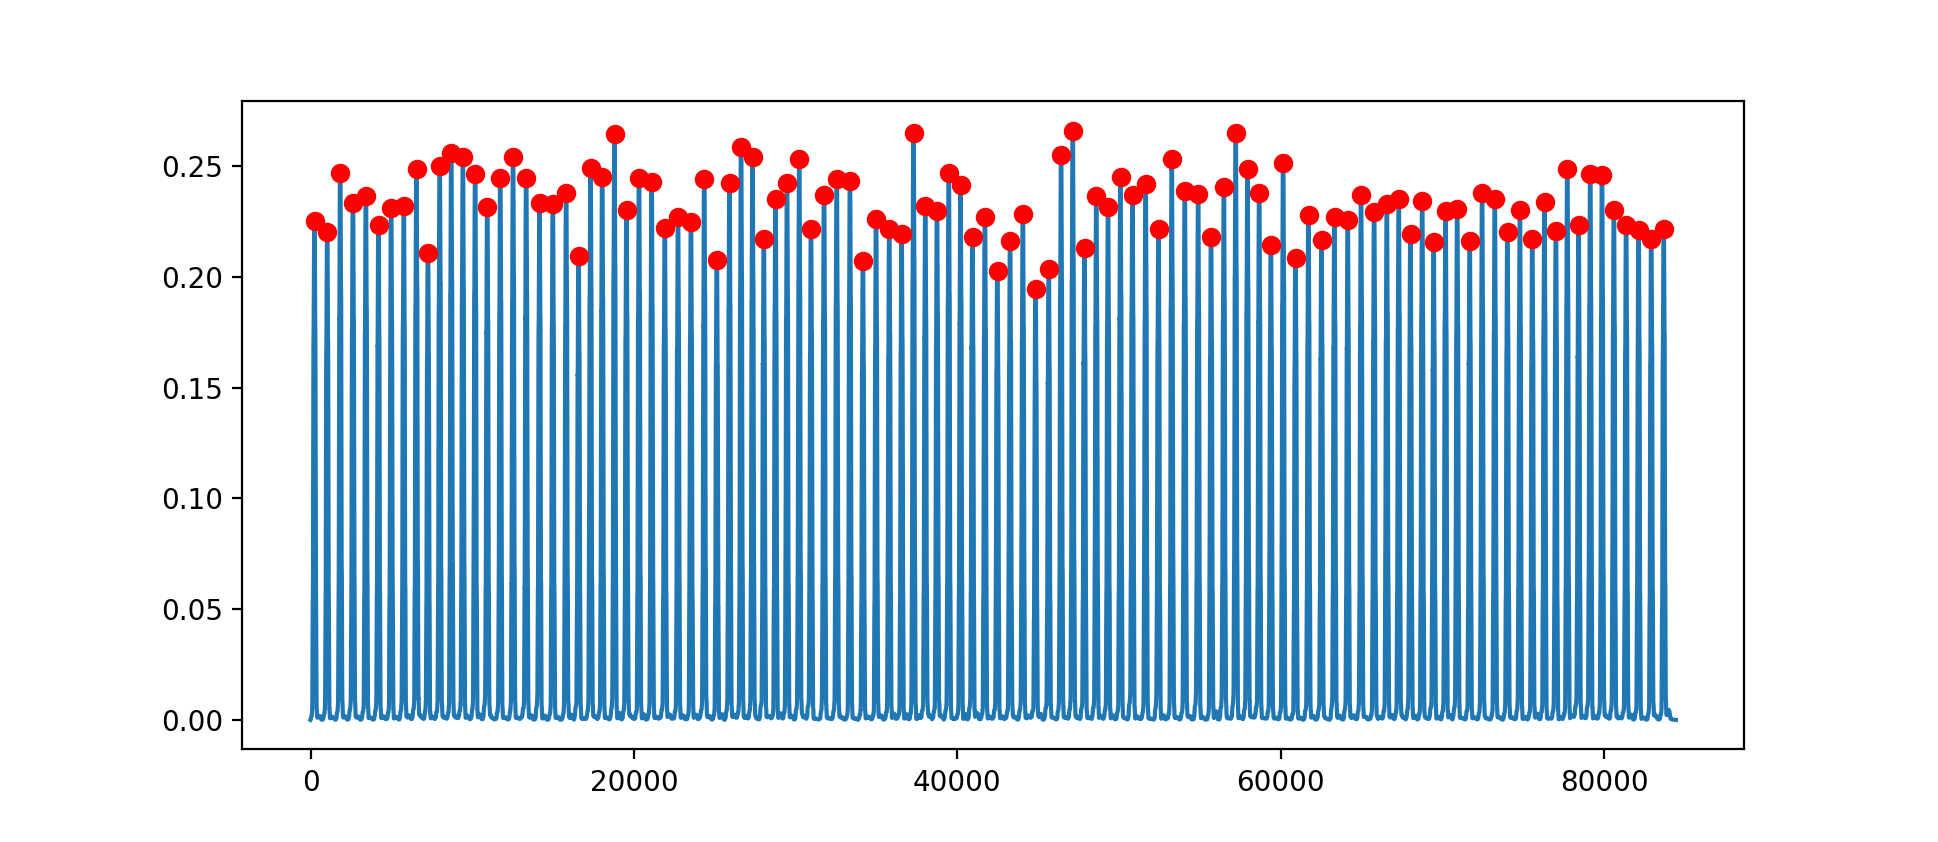

<IPython.core.display.Javascript object>


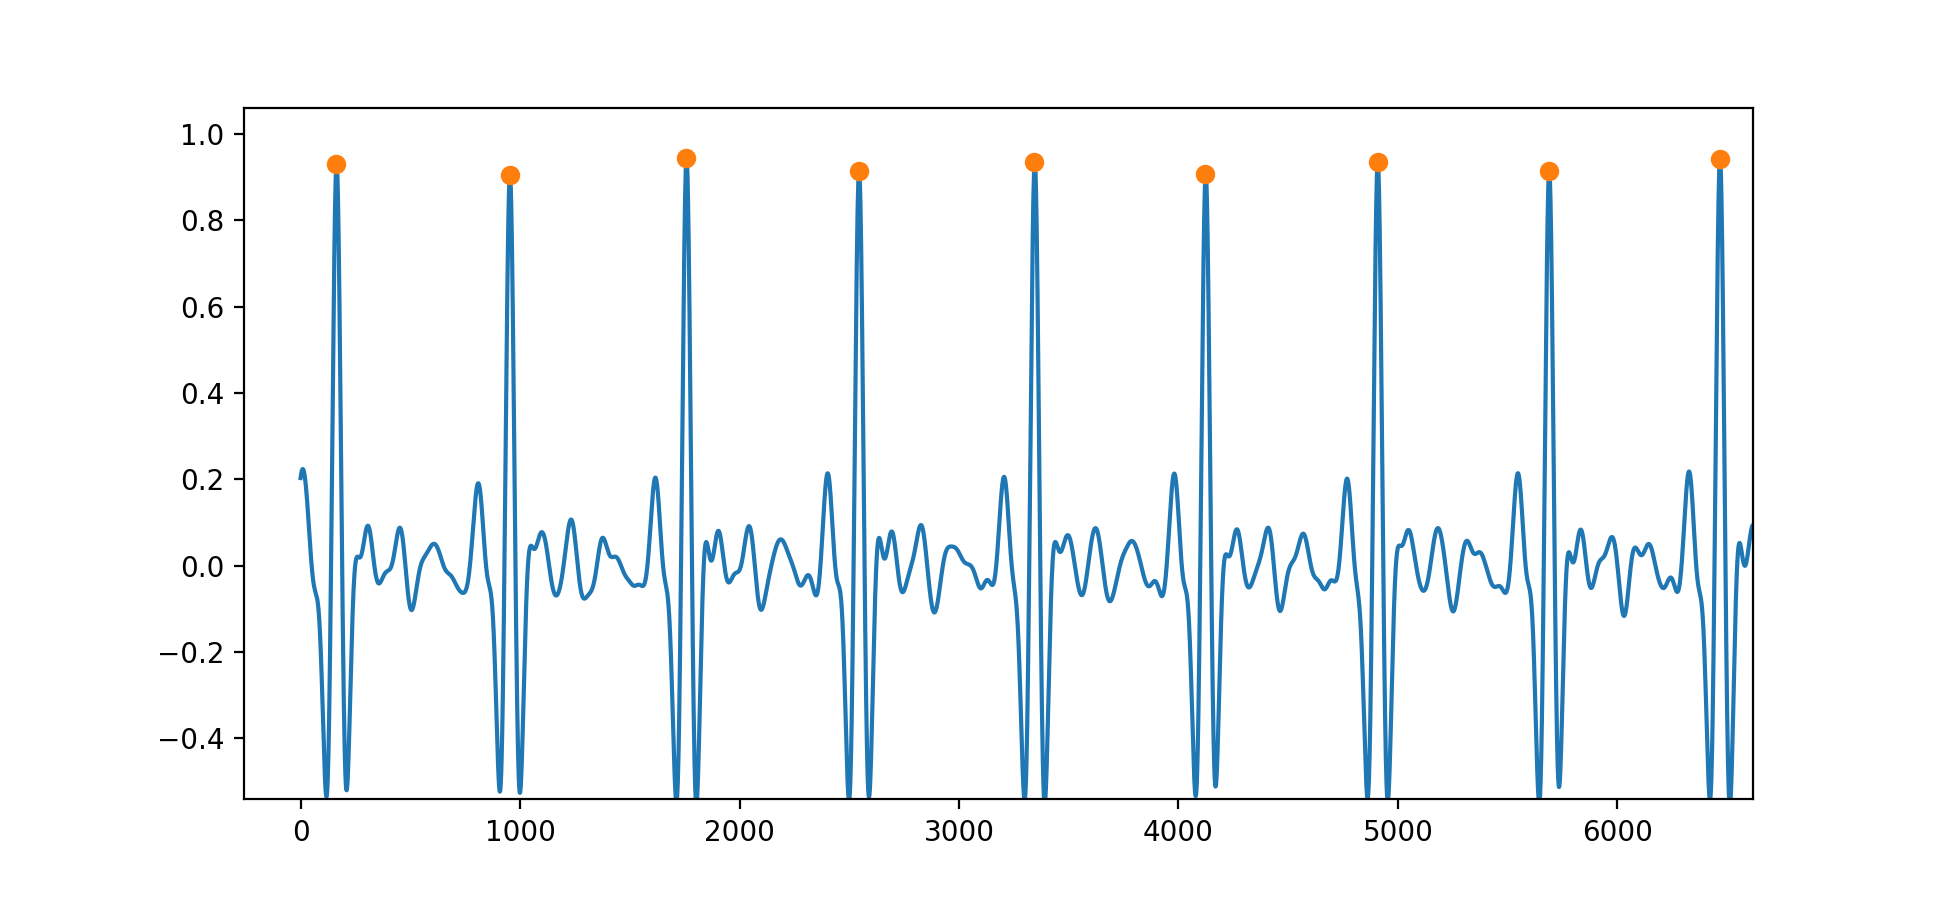

In [7]:
# Init
fs = 1000 # This could change by user
gr = 1
ecg_original = ecg_original - np.mean(ecg_original)

ecg_h, qrs_amp_raw, qrs_i_raw, delay = pan_tompkin(ecg_original, fs)
plt.figure()
plt.plot(ecg_h)
plt.plot(qrs_i_raw, qrs_amp_raw, 'o')